# ViT (Vision Transformer)
An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

https://arxiv.org/abs/2010.11929

In [1]:
! pip install einops
! pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from torch import Tensor
import torch.optim as optim
from PIL import Image
import torchvision
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor

from tqdm import tqdm_notebook as tqdm

## Einops
https://einops.rocks/

Название - от функции .einsum(), которая производит суммирование в "нотации Эйнштейна"

In [3]:
from einops import rearrange

In [4]:
# создадим пример данных
a = torch.arange(18).reshape((1, 3, 6)).float()
b = torch.ones((6, 2)).float()
b[:, 0] *= -1
print(f"{a.shape}\n{a}\n")
print(f"{b.shape}\n{b}")

torch.Size([1, 3, 6])
tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9., 10., 11.],
         [12., 13., 14., 15., 16., 17.]]])

torch.Size([6, 2])
tensor([[-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.],
        [-1.,  1.]])


In [5]:
# Запись через einsum
c = torch.einsum('bnc,ck->bnk', a, b)
print(f"{c.shape}\n\n{c}")

torch.Size([1, 3, 2])

tensor([[[-15.,  15.],
         [-51.,  51.],
         [-87.,  87.]]])


In [6]:
# То же самое через tensordot
torch.tensordot(a, b, dims=[[2], [0]])

tensor([[[-15.,  15.],
         [-51.,  51.],
         [-87.,  87.]]])

In [7]:
# в einsum порядок осей выхода можно менять
torch.einsum('bnc,ck->bkn', a, b)

tensor([[[-15., -51., -87.],
         [ 15.,  51.,  87.]]])

In [8]:
# einsum ~ .tensordot + .permute
torch.tensordot(a, b, dims=[[2], [0]]).permute(0, 2, 1)

tensor([[[-15., -51., -87.],
         [ 15.,  51.,  87.]]])

In [9]:
from einops import rearrange

In [10]:
# плющим
rearrange(a, 'b n e -> (b n e)')


tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17.])

In [11]:
# плющим в другом порядке
rearrange(a, 'b n e -> (b e n)')


tensor([ 0.,  6., 12.,  1.,  7., 13.,  2.,  8., 14.,  3.,  9., 15.,  4., 10.,
        16.,  5., 11., 17.])

In [12]:
# разбиваем на части
rearrange(a, 'b n (k e) -> b k n e', k=2)

tensor([[[[ 0.,  1.,  2.],
          [ 6.,  7.,  8.],
          [12., 13., 14.]],

         [[ 3.,  4.,  5.],
          [ 9., 10., 11.],
          [15., 16., 17.]]]])

In [13]:
# убираем и добавляем единичную ось
rearrange(a, '1 n e -> e 1 n 1')

tensor([[[[ 0.],
          [ 6.],
          [12.]]],


        [[[ 1.],
          [ 7.],
          [13.]]],


        [[[ 2.],
          [ 8.],
          [14.]]],


        [[[ 3.],
          [ 9.],
          [15.]]],


        [[[ 4.],
          [10.],
          [16.]]],


        [[[ 5.],
          [11.],
          [17.]]]])

### **Строение Модели ViT**

- Эмбеддинг фрагментов изображений -  отображает фрагмент в вектор признакового пространства

- Transformer encoder - кодирует последовательность патчей

- Голова, предсказывающая нужный класс

![VIT](images/vit.png)

**Multi-head attention**

![Encoder](images/mha.png)

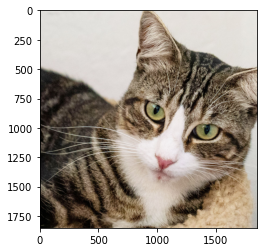

In [14]:
img = Image.open('images/cat.jpg')

fig = plt.figure()
plt.imshow(img)

In [15]:
#Приведем входное изображение к фомату ImageNet
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

In [16]:
from einops.layers.torch import Rearrange
from einops import repeat


In [25]:
class PatchEmbedding(nn.Module):
    """
    Разбиваем изображения на патчи
    Формируем из них токены
    Добавляем "классовый" токен
    Суммируем с positional encoding
    """
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 512, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        # Отображения последовательности патчей в пространство
        self.projection = nn.Sequential(
            # свертка ниже "сливает" патчи в один вектор
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            # свертка ниже "сливает" патчи в один вектор
            Rearrange('b e h w -> b (h w) e'),
        )
        # Токен начала изображения
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        # Позиция патча на изображении
        """
        Position embeddings are added to the patch embeddings to retain positional information. 
        We use standard learnable 1D position embeddings, since we have not observed 
        significant performance gains from using more advanced 2D-aware position embedding
        """
        self.positions = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        # Создадим массив токенов 
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # В начало каждого батча добавим токен начала
        x = torch.cat([cls_tokens, x], dim=1)
        # Добавляем позиционный эмбеддинг
        x += self.positions
        return x

    
pe = PatchEmbedding()
y1 = pe(x)
y1.shape

torch.Size([1, 197, 512])

In [30]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor) -> Tensor:
        # split keys, queries and values in num_heads
        pattern = "b n (h e) -> b h n e"
        queries = rearrange(self.queries(x), pattern, h=self.num_heads)
        keys = rearrange(self.keys(x), pattern, h=self.num_heads)
        values  = rearrange(self.values(x), pattern, h=self.num_heads)
        # sum up over the last axis
        # batch, num_heads, query_len, key_len
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) 
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # use values
        out = torch.einsum('bhqk, bhkv -> bhqv', att, values)
        out = rearrange(out, "b h q v -> b q (h v)")
        out = self.projection(out)
        return out    

mh = MultiHeadAttention()
y2 = mh(y1)
y2.shape

torch.Size([1, 197, 512])

In [31]:
class ResidualAdd(nn.Module):
    """
    Skip-connection вокруг произвольной функции
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        return x + self.fn(x, **kwargs)

ra = ResidualAdd(mh)
y3 = ra(y1)

In [34]:
class FeedForwardBlock(nn.Sequential):
    """
    Он же MLP(двуслойный).
    FFB как в оригинальном трансформере:
    - проекция в "расширенное" пространство
    - активация и дропаут
    - проекция обратно в исходный размер
    """
    def __init__(self, emb_size: int = 512, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, emb_size * expansion),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(emb_size * expansion, emb_size)
        )

tr = FeedForwardBlock()   
y4 = tr(y1)
y4.shape

torch.Size([1, 197, 512])

![Encoder](images/encoder.png)

In [35]:
class TransformerEncoderBlock(nn.Sequential):
    """
    Encoder как в оригинальном трансформере:
    - блок(skip-conn, add & norm вокруг multi-head attention)
    - блок(skip-conn, add & norm вокруг feed forward)     
    """
    def __init__(self,
                 emb_size: int = 512,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size=emb_size)
            )),

            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size=emb_size)
            ))
            
            
        )
        
tc = TransformerEncoderBlock()
tc(y1)

tensor([[[ 0.1524,  1.8845,  1.7474,  ..., -0.8609, -0.7184,  0.4339],
         [-0.8736,  0.9263,  0.3906,  ..., -0.8675,  1.2495, -0.8850],
         [-0.0777, -0.0308,  0.6479,  ..., -0.3942,  0.2193, -2.2147],
         ...,
         [ 1.3524,  1.6370, -0.0483,  ...,  0.1704,  1.4683, -2.5791],
         [ 1.4260,  1.6270, -0.8868,  ...,  0.8306, -0.9645, -0.4449],
         [-1.9794,  1.8332, -0.4129,  ..., -0.0542,  1.0460, -1.9358]]],
       grad_fn=<AddBackward0>)

In [36]:
class TransformerEncoder(nn.Sequential):
    """
    N одинаковых TransformerEncoderBlock
    """
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
        
tc = TransformerEncoder()
tc(y1)

tensor([[[-0.1819,  0.2274,  1.6425,  ...,  0.6541, -1.3591,  0.9011],
         [ 0.2692, -0.3394,  0.8487,  ..., -1.1486,  0.4737, -0.0793],
         [-0.7851,  0.5358,  1.2980,  ...,  0.6453, -0.1000, -1.8888],
         ...,
         [ 1.7626,  0.2658, -0.7319,  ...,  1.3818,  1.5180, -2.4996],
         [ 1.6183,  0.7053,  0.6169,  ...,  1.5820, -1.6312, -0.7592],
         [-1.7613,  2.0216,  0.8584,  ..., -0.8415, -0.3051, -2.4050]]],
       grad_fn=<AddBackward0>)

In [37]:
from einops.layers.torch import Reduce

class ClassificationHead(nn.Sequential):
    """
    Голова для классификации
    """
    def __init__(self, emb_size: int = 512, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes)
        )

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [38]:
from torchsummary import summary

model = ViT(n_classes=10, img_size=32, patch_size=8, emb_size=128)
summary(model, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 4, 4]          24,704
         Rearrange-2              [-1, 16, 128]               0
    PatchEmbedding-3              [-1, 17, 128]               0
         LayerNorm-4              [-1, 17, 128]             256
            Linear-5              [-1, 17, 128]          16,512
            Linear-6              [-1, 17, 128]          16,512
            Linear-7              [-1, 17, 128]          16,512
           Dropout-8            [-1, 8, 17, 17]               0
            Linear-9              [-1, 17, 128]          16,512
MultiHeadAttention-10              [-1, 17, 128]               0
      ResidualAdd-11              [-1, 17, 128]               0
        LayerNorm-12              [-1, 17, 128]             256
           Linear-13              [-1, 17, 512]          66,048
             ReLU-14              [-1,

In [34]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
model = model.cuda()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

C:\Users\bzimka\AppData\Local\Temp\ipykernel_20024\2300219733.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader), leave=False):


  0%|          | 0/3125 [00:00<?, ?it/s]

[1,  2000] loss: 1.955


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,  2000] loss: 1.629


  0%|          | 0/3125 [00:00<?, ?it/s]

[3,  2000] loss: 1.511


  0%|          | 0/3125 [00:00<?, ?it/s]

[4,  2000] loss: 1.420


  0%|          | 0/3125 [00:00<?, ?it/s]

[5,  2000] loss: 1.352


  0%|          | 0/3125 [00:00<?, ?it/s]

[6,  2000] loss: 1.300


  0%|          | 0/3125 [00:00<?, ?it/s]

[7,  2000] loss: 1.248


  0%|          | 0/3125 [00:00<?, ?it/s]

[8,  2000] loss: 1.194


  0%|          | 0/3125 [00:00<?, ?it/s]

[9,  2000] loss: 1.150


  0%|          | 0/3125 [00:00<?, ?it/s]

[10,  2000] loss: 1.100
Finished Training


In [40]:
from sklearn.metrics import accuracy_score

        # sum up over the last axis

result = []
gt = []
for i, data in tqdm(enumerate(testloader, 0), total=len(testloader)):
    inputs, labels = data
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    outputs = outputs.cpu().detach().numpy().argmax(axis=1)
    result = [*result, *outputs]
    gt = [*gt, *labels.cpu().detach().numpy()]
result = np.array(result).flatten()
gt = np.array(gt).flatten()
accuracy_score(result, gt)

C:\Users\bzimka\AppData\Local\Temp\ipykernel_20024\916747028.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm(enumerate(testloader, 0), total=len(testloader)):


  0%|          | 0/625 [00:00<?, ?it/s]

0.5678

## Полезные ссылки
- https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632